In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MODEL: CNN

# **Topic: Covid-19 image classification**

##**Data resource: Kaggle**
covid19-image-dataset

https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/data
---

##**Model Architecture**

1. Data Preprocessing.
  * Resize Images: Resize all input images to a consistent size, e.g., 150x150.
  * Normalization: Scale pixel values to a range of 0-1 by dividing by 255.

2. Model Training
  * CNN - **ResNet** (Best for Large DS)
  * Layer - activation(ReLU or sigmoid)

3. Fine-Tuning (After Model Training)
4. Evaluate model
  * **Confusion Matrix:** Provides a summary of the prediction results, showing true positives, false positives, false negatives, and true negatives.
  * **Accuracy:** Measures the overall percentage of correctly classified instances. It is calculated as the ratio of correctly predicted instances to the total instances.
  * **Precision:** Indicates how many of the positive predictions made by the model are actually correct. It is the ratio of true positives to the sum of true positives and false positives.
  * **Recall (Sensitivity):** Represents how many actual positive instances the model correctly identified. It is the ratio of true positives to the sum of true positives and false negatives.
  * **F1 Score:** The harmonic mean of precision and recall, providing a single metric that balances both. It is particularly useful when you have an uneven class distribution.
  * **AUC (Area Under the Curve):** A measure of the model's ability to distinguish between classes. For binary classification, it’s the area under the ROC curve; for multiclass, it’s averaged using a one-vs-rest approach.

  
5. Result
  * visualisation
  * Implementation


In [2]:
cd /content/drive/MyDrive/AT2IntrotoAI

/content/drive/MyDrive/AT2IntrotoAI


In [ ]:
#Torch provides basic classes for defining and operating on tensors
import torch
#Torch.nn includes prefefined layers and loss functions
import torch.nn as nn
#Torch.optim provides optimisation algorithms for adjusting model weights
import torch.optim as optim
#torchvision provides data transformation options and data augmentation techniques
from torchvision import datasets, transforms, models
#DataLoader handles the loading of datasets, batching, shuffling and parrallel data loading
from torch.utils.data import DataLoader

# Image Resizing


1.   Ensures consistent input size for preventing errors during batch processing.
2. Pretrained models are designed to acccept images of a fixed size so image resizing is essential for ensuring the model works.
3. Image resizing also ensures efficient computation



In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #Converts the image into a PyTorch tensor and scales the pixels
    #Standard format for feeding data into PyTorch Models
    transforms.ToTensor(),
    #Adjusts mean and standard deviation of the images to ensure inputs are consistent
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data train and Test Initialisation

This focuses on creating training and testing loaders in order to train the model and test it using the images that have the covid images and normal images

In [ ]:
#ImageFolder used to load images from the directory according to class labels
#Images within the folders are automatically assigned class labels i.e. 'test' and 'train'
train_dataset = datasets.ImageFolder(root='Covid19-dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='Covid19-dataset/test', transform=transform)

#Batches the training data with each batch including 32 imaeges
#shuffle randomises the order of the data to avoid including order-based biases when learning
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training Method

The `train_model()` will be used to train the model by running specific number of epoch and will use a specifc optimizer in order to reduce the errors and calcuates the eopch metrics which shows the accuracy of the models and will return the most optimal one

In [ ]:
#Defines a function to train the model
def train_model(model, criterion, optimizer, num_epochs=10):
  #Iterates over epochs to show training progress
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # Activates training settings like dropout and batch normalization
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterates through the dataset provided in train loader
        #Sets the model to training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            #Ensures data from the previous batch don't accumulate
            optimizer.zero_grad()
            #Passes inputs through the model to get predictions
            outputs = model(inputs)
            #Measures the difference between predictions and true labes
            loss = criterion(outputs, labels)
            #Calculates gradiants of the loss
            loss.backward()
            #Updates models using the gradients
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            #Adds batch loss scaled by batch size
            running_loss += loss.item() * inputs.size(0)
            #Increments by the number of correct predictions
            running_corrects += torch.sum(preds == labels.data)

        #Calculates Epoch Metrics
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Training complete.')
    return model

# ResNet Model and Training

We have used ResNet 18 version to classify the images as either covid or non covid.

**Solving the Covid Image classification Problem**

First there are two components:
1.   Convolutional Operation
2.   Max Pooling

**Convolutional Operation**

Convolutional operation consists of the picture which is a matrix of 224 usually each cell for ResNet has RGB value between 0 to 255 along with a kernel which represents a filter that can either detect horizontal edges or vertical edges or etc. The kernel will slide through the picture matrix and calculate the new matrix which identifies the edges.

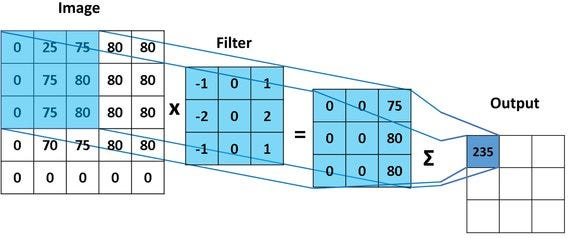

In this image it shows how it slides over the image and calculates the values of the new matrix by multiplying and adding them together.

**Pooling**

This helps to reduce the memory usage and the best way it works is through max pooling in which it selects the maximum numbers for each 3x3 or 2x2. Uusally for the ResNet 18 it takes 3x3 Max Pooling

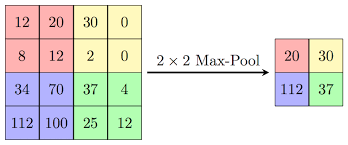

In this picture it takes the maximum numbers for each 2x2 and stores them in 2x2 matrix.

**ResNet 18**

For the ResNet 18 it uses the convolutional operation along with the max pooling in order to do the following operatios

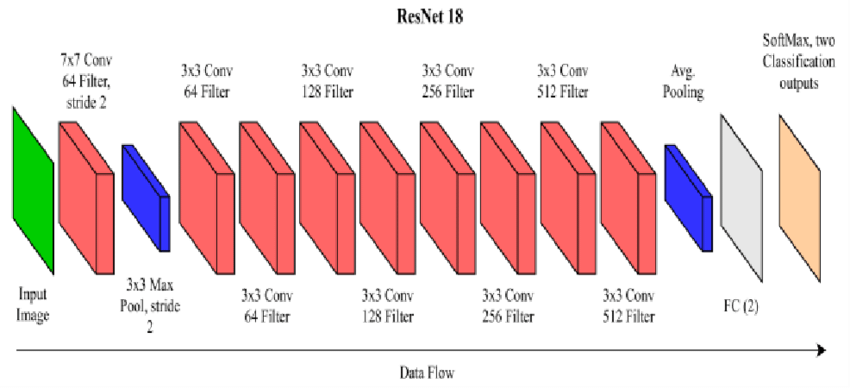

As shown in the figure above it takes the input image which is initially 224 and then it does 7x7 Convolutional operation along with 64 filters, After that Max Pooling is done with 3x3 matrix to reduce the dimensions and then 3x3 convolutional operation is done again with 64 filters twice then it will be done again, however, with 128 filters twice then it will be done with 256 filters twice and finally it will be done with 512 filters twice. After that it will do Average pooling and once all of this is done we are left with plenty of filters which will be used in the fully connected neural network in order to train the model and determine whether the image shows that it detects covid or not.

In [ ]:
#Initialises ResNet-18 with pretrained weights from the ImageNet dataset
model = models.resnet18(weights='IMAGENET1K_V1')  # Updated method to use pre-trained weights
num_ftrs = model.fc.in_features

#Adjusts model models final fully connected layer to output 2 classes
#Modification is needed as original ResNet-18 is designed for 1000 ImageNet classes
model.fc = nn.Linear(num_ftrs, 2)

# Sets the computational device to GPU if available and defaults to CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
#Loss function evaluates the error between predicted and true labels
criterion = nn.CrossEntropyLoss()
#The optimiser Adam is used for its adaptive learning capabilities and simplicity
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = train_model(model, criterion, optimizer)

# Serialises model's state dictionary to a file for later use
torch.save(model.state_dict(), 'simplified_resnet_covid_classifier.pth')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


Epoch 1/10
Training Loss: 0.3664 Acc: 0.8508
Epoch 2/10
Training Loss: 0.0749 Acc: 0.9779
Epoch 3/10
Training Loss: 0.0867 Acc: 0.9724
Epoch 4/10
Training Loss: 0.0087 Acc: 0.9945
Epoch 5/10
Training Loss: 0.0051 Acc: 1.0000
Epoch 6/10
Training Loss: 0.0028 Acc: 1.0000
Epoch 7/10
Training Loss: 0.0008 Acc: 1.0000
Epoch 8/10
Training Loss: 0.0036 Acc: 1.0000
Epoch 9/10
Training Loss: 0.0004 Acc: 1.0000
Epoch 10/10
Training Loss: 0.0031 Acc: 1.0000
Training complete.


# Testing and Evaluation

This will test the predictions by displaying each tetsing image and showing the prediction of the model and showing the actual output

In [ ]:
#Loads Dependencies
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Retrieves the saved model
model.load_state_dict(torch.load('simplified_resnet_covid_classifier.pth'))
# Sets the model to evaluation mode which disables certain layers only used in training i.e. dropout
model.eval()

# Define a function to convert tensor to image (for visualization)
# Unnormalising values i.e. reverting back to the original images' mean and standard deviation
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Disable gradient calculations during prediction to reduce memory usage and increase efficiency
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Feeds input images through the model to get output
        outputs = model(inputs)
        #Selects the class with the highest score for each image
        _, preds = torch.max(outputs, 1)

        # Move inputs, predictions, and actual labels back to CPU for further operations and visualisations
        inputs = inputs.cpu()
        preds = preds.cpu()
        labels = labels.cpu()

        # Iterate through each batch and display the image along with its predicted and actual label
        for i in range(inputs.size(0)):
            img = inputs[i]  # Select the ith image in the batch
            predicted_label = preds[i].item()  # Get the predicted label for ith image
            actual_label = labels[i].item()    # Get the actual label for ith image

            # Convert the predicted and actual label index to class names
            predicted_class = train_dataset.classes[predicted_label]
            actual_class = train_dataset.classes[actual_label]

            # Display the image and the predicted/actual labels
            imshow(img, f'Predicted: {predicted_class}, Actual: {actual_class}')

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# List to store actual and predicted labels for entire test dataset
all_preds = []
all_labels = []

# Disable gradient calculations during prediction to save memory
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Model prediction
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch predictions and labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)



Output hidden; open in https://colab.research.google.com to view.

This is the confusion matrix which checks the amount of times the model predicts correct and wrong things

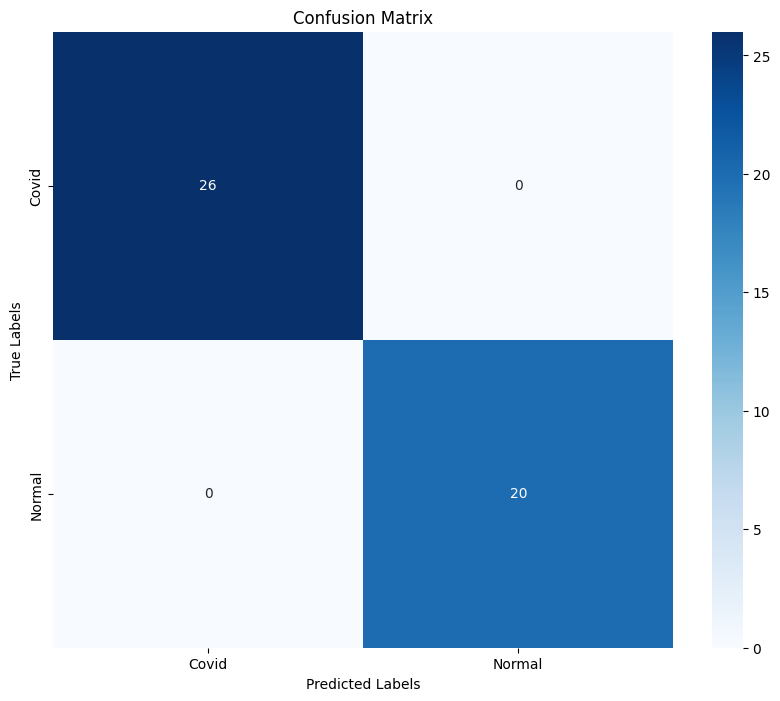


Classification Report:
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00        26
      Normal       1.00      1.00      1.00        20

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(all_labels, all_preds, average='weighted')  # 'weighted' for multiclass
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# For AUC, check if the task is binary classification
if len(set(all_labels)) == 2:
    auc = roc_auc_score(all_labels, all_preds)
else:
    auc = roc_auc_score(all_labels, model(torch.FloatTensor(all_preds)).detach().numpy(), multi_class='ovr')

# Print the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
if len(set(all_labels)) == 2:
    print(f'AUC: {auc:.4f}')
else:
    print("AUC (multi-class):", auc)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("\nClassification Report:")
print(class_report)